
## Imports

In [137]:
# %pip install tqdm
from tqdm.auto import tqdm

In [138]:
from IPython.display import display

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, mutual_info_score, roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

## Utilities

In [139]:
def numerical_features(df: pd.DataFrame):
    cols = df.columns[ (df.dtypes != 'object') ]
    return list(cols)

def categorical_features(df: pd.DataFrame):
    cols = df.columns[ (df.dtypes == 'object') ]
    return list(cols)

In [140]:
def validation_testing_training_full_split(dataframe: pd.DataFrame, seed: int = 42, validation: float = 0.2, testing: float = 0.2):
    assert 0 < validation and 0 < testing and 1 > (validation + testing)

    validation_of_full = validation / (1 - testing)
    if validation_of_full == 0:
        validation_of_full = None
        
    df_full,     df_testing    = train_test_split(dataframe, test_size=testing,            random_state=seed, shuffle=True)
    df_training, df_validation = train_test_split(df_full,   test_size=validation_of_full, random_state=seed, shuffle=True)
    
    df_validation = df_validation.reset_index(drop=True)
    df_testing = df_testing.reset_index(drop=True)
    df_training = df_training.reset_index(drop=True)
    df_full = df_full.reset_index(drop=True)
    
    return df_validation, df_testing, df_training, df_full

In [141]:
def y_split(dataframe: pd.DataFrame, yColumn: str, drop: list[str] = []):
    columns = set(dataframe.columns)   
    assert columns.issuperset([yColumn]), f'{yColumn} not found in dataframe'
    assert columns.issuperset(drop), f'At least one of {drop} not found in dataframe'
    
    df = dataframe.copy()
    y = df[yColumn]
    for col in drop + [yColumn]:
        del df[col]
        
    return df, y

In [142]:
def regularize(X, r=0.000000001):
    return X + np.eye(X.shape[0]) * r

In [143]:
# def regularize(X, r: float = 0.00000001):
#     return X if r == 1 else X + np.eye(X.shape[0]) * r
#     
# X = [
#     [1, 2, 2],
#     [2, 1, 1], # r
#     [2, 1, 1], # r
#     [0, 9, 9],
#     [1, 0, 0],
# ] #     c  c
# X = np.array(X)
# XTX = X.T.dot(X)
# print(XTX) # duplicate columns is an issue for linear / logistic regression
# np.linalg.inv(XTX)
# 
# regularize(X, r=0.01)

In [144]:
def sigmoid(score):
    return 1 / (1 + np.exp(-score))

# z = np.linspace(-5, 5, 51)
# plt.plot(z, sigmoid(z))

In [145]:
def display_predictive_features_for_target(df: pd.DataFrame, target: str, categorical = []):
    global_target = df[target].mean()
    for c in categorical:
        df_group = df.groupby(c)[target].agg('mean','count')
        df_group['diff'] = df_group.mean - global_target
        df_group['risk'] = df_group.mean / global_target
        display(df_group)

In [146]:
def one_hot_encode(df: pd.DataFrame, drop: list[str] = [], dv: DictVectorizer = DictVectorizer(sparse=False), fit: bool = False):
    assert set(df.columns).issuperset(drop), f'At least one of {drop} is not found in the DataFrame `df`'
    
    df_encode = df.copy()
    for feature in drop:
        del df_encode[feature]
    
    data = df_encode.to_dict(orient='records')
    X = dv.fit_transform(data) if fit else dv.transform(data)
        
    assert len(dv.feature_names_) == X.shape[1]
    return X, dv

In [147]:
def fit(model: LinearRegression | LogisticRegression, df: pd.DataFrame, y: pd.Series, drop: list[str] = []) -> tuple[LinearRegression | LogisticRegression, DictVectorizer]:
    assert df.shape[0] == y.shape[0], '`df` and `y` mismatch'
    
    X, dv = one_hot_encode(df, drop, fit=True)
    model.fit(X, y)
    
    return model, dv

In [148]:
def predict(model: LinearRegression | LogisticRegression, dv: DictVectorizer, df: pd.DataFrame, drop: list[str] = []):
    X, _ = one_hot_encode(df, drop, dv)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [149]:
def random_predictions(y: pd.Series, seed: int = 42):
    np.random.seed(seed)
    if y.dtype == 'bool':
        return np.random.uniform(0, 1, size=len(y))
    else:
        return np.random.uniform(0, 1, size=len(y))

In [150]:
def model_metrics(y: pd.Series, y_pred: pd.Series, threshold: float = 0.5):
    assert len(y) == len(y_pred), "`y` and `y_pred` mismatch"
    assert 0 <= threshold and threshold <= 1, "invalid threshold"
    
    actual_positive = (y == 1)
    actual_negative = (y == 0)
    predicted_positive = (y_pred >= threshold)
    predicted_negative = (y_pred < threshold)
    
    true_positive = (predicted_positive & actual_positive).sum()
    false_positive = (predicted_positive & actual_negative).sum()
    false_negative = (predicted_negative & actual_positive).sum()
    true_negative = (predicted_negative & actual_negative).sum()
    
    # Accuracy = ratio of correct predictions -- false and positive 
    # accuracy = proportional_matrix[0,0] + proportional_matrix[1,1]
    accuracy = (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)
    
    # Precision = ratio of correct to positive predictions; higher is better
    precision = true_positive / (true_positive + false_positive)
    # Recall = ratio of correctly predicted positive; higher is better
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    # TPR = ratio of true positives in all positives; higher is better
    # true_positive_rate = recall
    true_positive_rate  = true_positive / ( false_negative + true_positive)
    # FPR = ratio of false positives in all negatives; lower is better
    false_positive_rate = false_positive / (true_negative + false_positive)
    
    matrix = np.array([
        #   g(Xi) < t    |   g(Xi) >= t
        [ true_negative  , false_positive ], # y == 0
        [ false_negative , true_positive  ]  # y == 1
    ])
    
    proportional_matrix = (matrix / matrix.sum()).round(6)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': true_positive,
        'fp': false_positive,
        'fn': false_negative,
        'tn': true_negative,
        'tpr': true_positive_rate,
        'fpr': false_positive_rate,
        'confusion': matrix,
        'proportional_confusion': proportional_matrix
    }

In [151]:
def model_metrics_for_thresholds(y: pd.Series, y_pred: pd.Series, thresholds: list[float]) -> pd.DataFrame:
    results = []
    for threshold in thresholds:
        metrics = model_metrics(y, y_pred, threshold)
        metrics['threshold'] = threshold
        results.append(metrics)
        
    df_metrics = pd.DataFrame(results)
    df_metrics.set_index('threshold', inplace=True)
    
    return df_metrics

## Data Preparation

In [152]:
df = pd.read_csv('../03-classification//bank-full.csv', sep=';')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Drop excluded features (see homework instructions)

In [153]:
for col in df.columns:
    if col not in ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']:
        del df[col]
        
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5
month,may,may,may,may,may
duration,261,151,76,92,198


### Make `y` binary

In [154]:
df['encoded_y'] = df.y.str.lower() == 'yes' 
df['y'] = df['encoded_y'].astype(int)
del df['encoded_y']
df.tail().T

,45206,45207,45208,45209,45210
age,51,71,72,57,37
job,technician,retired,retired,blue-collar,entrepreneur
marital,married,divorced,married,married,married
education,tertiary,primary,secondary,secondary,secondary
balance,825,1729,5715,668,2971
housing,no,no,no,no,no
contact,cellular,cellular,cellular,telephone,cellular
day,17,17,17,17,17
month,nov,nov,nov,nov,nov
duration,977,456,1127,508,361


### Split the data

#### Training, Testing, Validation, & Full (Training + Validation)

In [155]:
df_val, df_test, df_train, df_full = validation_testing_training_full_split(df, seed=1)

nTotal = len(df)
nVal = len(df_val)
nTest = len(df_test)
nTrain = len(df_train)
nFull = len(df_full)

round(nVal/nTotal, 1), round(nTest/nTotal, 1), round(nTrain/nTotal, 1), round(nFull/nTotal,1), round(nTotal/nTotal)

(0.2, 0.2, 0.6, 0.8, 1)

#### Split out `y` (target feature) from all datasets 

In [156]:
df_val, y_val = y_split(df_val, 'y')
df_test, y_test = y_split(df_test, 'y')
df_train, y_train = y_split(df_train, 'y')
df_full, y_full = y_split(df_full, 'y')

assert df_val.shape[1] == df_test.shape[1] and df_test.shape[1] == df_train.shape[1] and df_train.shape[1] == df_full.shape[1]
assert len(y_val) == df_val.shape[0] and len(y_test) == df_test.shape[0] and len(y_train) == df_train.shape[0] and len(y_full) == df_full.shape[0]

In [157]:
df_train.head().T

,0,1,2,3,4
age,56,33,32,40,54
job,entrepreneur,technician,technician,admin.,unemployed
marital,married,married,single,divorced,married
education,tertiary,secondary,tertiary,secondary,tertiary
balance,40,4790,392,2129,1180
housing,no,yes,yes,no,no
contact,cellular,cellular,cellular,cellular,cellular
day,11,20,21,30,19
month,jul,apr,nov,apr,nov
duration,123,137,148,452,394


In [158]:
df_train.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

## Answers

### Question 1: ROC AUC feature importance

In [159]:
for feature in numerical_features(df_train):
    auc = roc_auc_score(y_train, df_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
    print(f'{feature:>10} has {auc = :.3f}')

       age has auc = 0.512
   balance has auc = 0.589
       day has auc = 0.526
  duration has auc = 0.815
  campaign has auc = 0.571
     pdays has auc = 0.590
  previous has auc = 0.599


Which numerical variable (among the following 4) has the highest AUC?

- `duration`

### Question 2: Training the model

In [160]:
model, dv = fit(LogisticRegression(solver='liblinear', C=1.0, max_iter=1000), df_train, y_train)
y_val_pred = predict(model, dv, df_val)
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc_score(y_val, y_val_pred)

0.9006884713944792

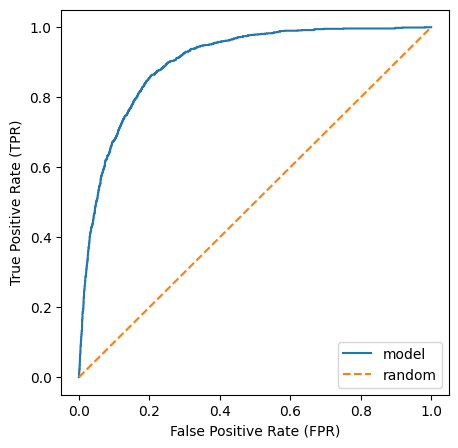

In [161]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.89

### Question 3: Precision and Recall

In [162]:
model_metrics(y_val, y_val_pred)

{'accuracy': 0.8974784339747843,
 'precision': 0.6546112115732369,
 'recall': 0.3296903460837887,
 'f1': 0.4385221078134464,
 'tp': 362,
 'fp': 191,
 'fn': 736,
 'tn': 7753,
 'tpr': 0.3296903460837887,
 'fpr': 0.02404330312185297,
 'confusion': array([[7753,  191],
        [ 736,  362]], dtype=int64),
 'proportional_confusion': array([[0.857443, 0.021124],
        [0.081398, 0.040035]])}

In [163]:
df_metrics = model_metrics_for_thresholds(y_val, y_val_pred, [t / 100 for t in range(0, 100)])
df_metrics

,accuracy,precision,recall,f1,tp,fp,fn,tn,tpr,fpr,confusion,proportional_confusion
threshold,,,,,,,,,,,,
0.00,0.121433,0.121433,1.000000,0.216568,1098,7944,0,0,1.000000,1.000000,"[[0, 7944], [0, 1098]]","[[0.0, 0.878567], [0.0, 0.121433]]"
0.01,0.220305,0.134398,0.996357,0.236848,1094,7046,4,898,0.996357,0.886959,"[[898, 7046], [4, 1094]]","[[0.099314, 0.779252], [0.000442, 0.120991]]"
0.02,0.356226,0.158199,0.995446,0.273011,1093,5816,5,2128,0.995446,0.732125,"[[2128, 5816], [5, 1093]]","[[0.235346, 0.643221], [0.000553, 0.12088]]"
0.03,0.468370,0.184770,0.989982,0.311417,1087,4796,11,3148,0.989982,0.603726,"[[3148, 4796], [11, 1087]]","[[0.348153, 0.530414], [0.001217, 0.120217]]"
0.04,0.570117,0.217427,0.977231,0.355710,1073,3862,25,4082,0.977231,0.486153,"[[4082, 3862], [25, 1073]]","[[0.451449, 0.427118], [0.002765, 0.118668]]"
...,...,...,...,...,...,...,...,...,...,...,...,...
0.95,0.880889,0.684211,0.035519,0.067532,39,18,1059,7926,0.035519,0.002266,"[[7926, 18], [1059, 39]]","[[0.876576, 0.001991], [0.11712, 0.004313]]"
0.96,0.880004,0.638298,0.027322,0.052402,30,17,1068,7927,0.027322,0.002140,"[[7927, 17], [1068, 30]]","[[0.876687, 0.00188], [0.118115, 0.003318]]"
0.97,0.879783,0.641026,0.022769,0.043975,25,14,1073,7930,0.022769,0.001762,"[[7930, 14], [1073, 25]]","[[0.877018, 0.001548], [0.118668, 0.002765]]"


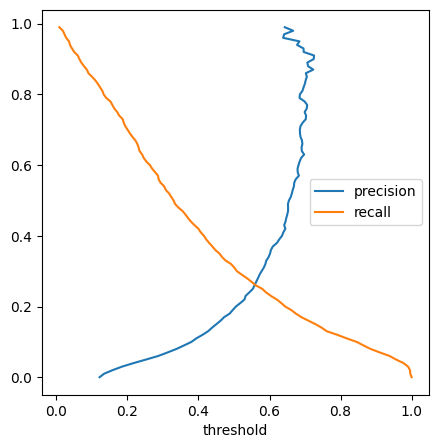

In [164]:
plt.figure(figsize=(5, 5))

plt.plot(df_metrics.precision, df_metrics.index, label='precision')
plt.plot(df_metrics.recall,    df_metrics.index, label='recall')

plt.xlabel('threshold')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.465


### Question 4: F1 score

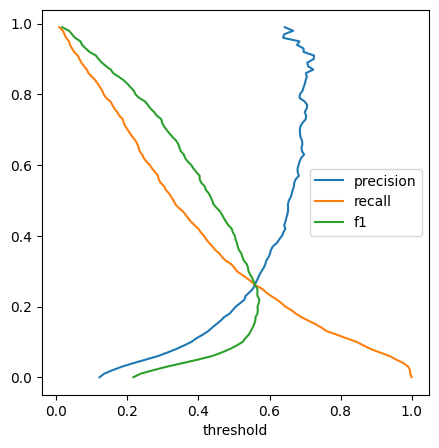

In [165]:
plt.figure(figsize=(5, 5))

plt.plot(df_metrics.precision, df_metrics.index, label='precision')
plt.plot(df_metrics.recall,    df_metrics.index, label='recall')
plt.plot(df_metrics.f1,        df_metrics.index, label='f1')

plt.xlabel('threshold')
plt.legend()

At which threshold F1 is maximal?

- 0.62

### Question 5: 5-Fold CV

In [166]:
folds = 5
kfold = KFold(n_splits=folds, shuffle=True, random_state=1)
scores = []

for training_indices, validation_indices in tqdm( kfold.split(df_full), total=folds ):
    df_training   = df_full.iloc[training_indices]
    y_training    = y_full .iloc[training_indices]
    df_validation = df_full.iloc[validation_indices]
    y_validation  = y_full . iloc[validation_indices]
    
    model, dv = fit(LogisticRegression(solver='liblinear', C=1.0, max_iter=1000), df_training, y_training)
    y_pred = predict(model, dv, df_validation)
    auc = roc_auc_score(y_validation, y_pred)
    
    scores.append(auc)
    
scores

100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


[0.8993733054494373,
 0.898944421423942,
 0.9112805043937209,
 0.9081388806828126,
 0.9119843456804715]

In [167]:
np.mean(scores), np.std(scores)

(0.9059442915260769, 0.005691215739889739)

How large is standard deviation of the scores across different folds?

- 0.006

### Question 6

In [168]:
folds = 5

for C in tqdm( [0.000001, 0.001, 1] ):
    scores = []
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)

    for training_indices, validation_indices in kfold.split(df_full):
        df_training   = df_full.iloc[training_indices]
        y_training    = y_full .iloc[training_indices]
        df_validation = df_full.iloc[validation_indices]
        y_validation  = y_full . iloc[validation_indices]
        
        model, dv = fit(LogisticRegression(solver='liblinear', C=C, max_iter=1000), df_training, y_training)
        y_pred = predict(model, dv, df_validation)
        auc = roc_auc_score(y_validation, y_pred)
        
        scores.append(auc)
    
    print(f'{C=:>.6f}: mean = {np.mean(scores):.3f}, std = {np.std(scores):.3f}')

 33%|███▎      | 1/3 [00:04<00:09,  4.85s/it]

C=0.000001: mean = 0.701, std = 0.009


 67%|██████▋   | 2/3 [00:10<00:05,  5.15s/it]

C=0.001000: mean = 0.861, std = 0.007


100%|██████████| 3/3 [00:16<00:00,  5.61s/it]

C=1.000000: mean = 0.906, std = 0.006


Which `C` leads to the best mean score?

- 1